# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

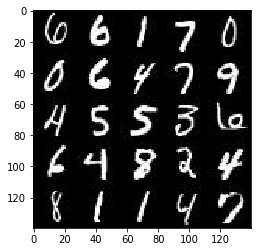

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

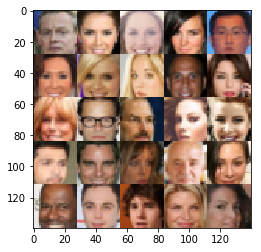

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels],
                                 name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 497, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/tornado/ioloop.py", line 832, in start\n    self._run_callback(self._callbacks.popleft())', 'File

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.1
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x(1,3)
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        drop1 = tf.nn.dropout(x1, 0.9)
        relu1 = tf.maximum(alpha * drop1, drop1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        drop2 = tf.nn.dropout(bn2, 0.9)
        relu2 = tf.maximum(alpha * drop2, drop2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        drop3 = tf.nn.dropout(bn3, 0.9)
        relu3 = tf.maximum(alpha * drop3, drop3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.1
    with tf.variable_scope('generator', reuse=(not is_train)):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.nn.dropout(x1, 0.9)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same',
                                       kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.nn.dropout(x2, 0.9)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same',
                                       kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.nn.dropout(x3, 0.9)
        x3 = tf.maximum(alpha * x3, x3)
        # 28x28x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same',
                                           kernel_initializer=tf.contrib.layers.xavier_initializer())
        # 28x28xout_channel_dim now
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                labels=tf.ones_like(d_model_real) * 0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """

    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    print_every = 50
    show_every = 500
    
    inputs_real, inputs_z, learning_rate_tf = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(inputs_real, inputs_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)

    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                #print(np.min(batch_images), np.max(batch_images))
                batch_images *= 2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z})
                _ = sess.run(g_opt, feed_dict={inputs_z: batch_z, inputs_real: batch_images})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({inputs_z: batch_z, inputs_real: batch_images})
                    train_loss_g = g_loss.eval({inputs_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, inputs_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.3962... Generator Loss: 0.9644
Epoch 1/2... Discriminator Loss: 2.0847... Generator Loss: 0.2991
Epoch 1/2... Discriminator Loss: 1.7167... Generator Loss: 0.4314
Epoch 1/2... Discriminator Loss: 0.9873... Generator Loss: 1.4451
Epoch 1/2... Discriminator Loss: 1.0172... Generator Loss: 0.8980
Epoch 1/2... Discriminator Loss: 0.7474... Generator Loss: 1.9086
Epoch 1/2... Discriminator Loss: 1.2479... Generator Loss: 1.1115
Epoch 1/2... Discriminator Loss: 1.5109... Generator Loss: 0.4997
Epoch 1/2... Discriminator Loss: 1.2384... Generator Loss: 0.7256
Epoch 1/2... Discriminator Loss: 1.2062... Generator Loss: 0.9837


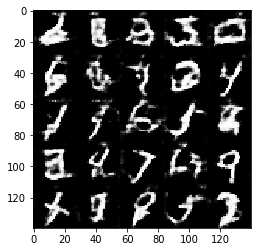

Epoch 1/2... Discriminator Loss: 1.3451... Generator Loss: 0.6360
Epoch 1/2... Discriminator Loss: 1.1135... Generator Loss: 1.1215
Epoch 1/2... Discriminator Loss: 1.8542... Generator Loss: 0.3354
Epoch 1/2... Discriminator Loss: 1.2627... Generator Loss: 1.7409
Epoch 1/2... Discriminator Loss: 1.5575... Generator Loss: 0.4406
Epoch 1/2... Discriminator Loss: 1.1011... Generator Loss: 0.8250
Epoch 1/2... Discriminator Loss: 1.3174... Generator Loss: 0.6442
Epoch 1/2... Discriminator Loss: 1.1854... Generator Loss: 1.4669
Epoch 1/2... Discriminator Loss: 1.2971... Generator Loss: 0.6598
Epoch 1/2... Discriminator Loss: 1.1425... Generator Loss: 0.7778


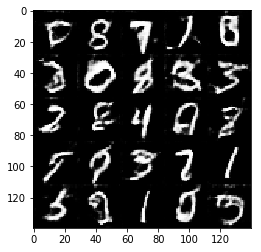

Epoch 1/2... Discriminator Loss: 1.2278... Generator Loss: 0.5969
Epoch 1/2... Discriminator Loss: 1.2352... Generator Loss: 0.6690
Epoch 1/2... Discriminator Loss: 0.9041... Generator Loss: 1.2944
Epoch 1/2... Discriminator Loss: 1.1048... Generator Loss: 0.8426
Epoch 1/2... Discriminator Loss: 0.9709... Generator Loss: 1.2724
Epoch 1/2... Discriminator Loss: 0.9408... Generator Loss: 1.3036
Epoch 1/2... Discriminator Loss: 1.0418... Generator Loss: 0.7875
Epoch 1/2... Discriminator Loss: 1.3171... Generator Loss: 1.4446
Epoch 1/2... Discriminator Loss: 0.9846... Generator Loss: 1.4756
Epoch 1/2... Discriminator Loss: 1.2542... Generator Loss: 0.9380


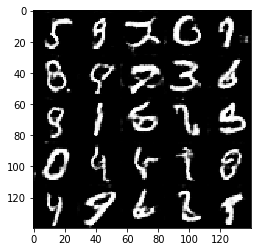

Epoch 1/2... Discriminator Loss: 0.9535... Generator Loss: 1.0567
Epoch 1/2... Discriminator Loss: 0.9378... Generator Loss: 1.3078
Epoch 1/2... Discriminator Loss: 0.7701... Generator Loss: 2.0548
Epoch 1/2... Discriminator Loss: 1.0293... Generator Loss: 1.7602
Epoch 1/2... Discriminator Loss: 1.0718... Generator Loss: 1.2817
Epoch 1/2... Discriminator Loss: 0.9581... Generator Loss: 1.7387
Epoch 1/2... Discriminator Loss: 1.5991... Generator Loss: 0.5128
Epoch 2/2... Discriminator Loss: 1.1163... Generator Loss: 2.1664
Epoch 2/2... Discriminator Loss: 1.3216... Generator Loss: 0.5923
Epoch 2/2... Discriminator Loss: 1.1812... Generator Loss: 1.0758


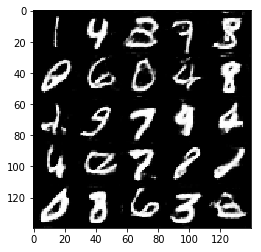

Epoch 2/2... Discriminator Loss: 1.4578... Generator Loss: 0.5852
Epoch 2/2... Discriminator Loss: 0.9469... Generator Loss: 1.1527
Epoch 2/2... Discriminator Loss: 1.4175... Generator Loss: 0.6252
Epoch 2/2... Discriminator Loss: 0.9348... Generator Loss: 1.4171
Epoch 2/2... Discriminator Loss: 1.0644... Generator Loss: 0.9443
Epoch 2/2... Discriminator Loss: 1.4117... Generator Loss: 0.6878
Epoch 2/2... Discriminator Loss: 0.9975... Generator Loss: 1.3700
Epoch 2/2... Discriminator Loss: 1.1150... Generator Loss: 0.7441
Epoch 2/2... Discriminator Loss: 1.4977... Generator Loss: 0.6264
Epoch 2/2... Discriminator Loss: 1.4509... Generator Loss: 0.5159


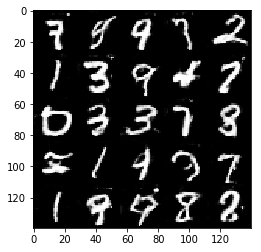

Epoch 2/2... Discriminator Loss: 0.7797... Generator Loss: 1.8894
Epoch 2/2... Discriminator Loss: 1.3002... Generator Loss: 0.8321
Epoch 2/2... Discriminator Loss: 1.3406... Generator Loss: 0.7823
Epoch 2/2... Discriminator Loss: 1.1841... Generator Loss: 0.7986
Epoch 2/2... Discriminator Loss: 0.8293... Generator Loss: 1.6406
Epoch 2/2... Discriminator Loss: 1.2988... Generator Loss: 0.8893
Epoch 2/2... Discriminator Loss: 0.8345... Generator Loss: 1.9108
Epoch 2/2... Discriminator Loss: 0.6757... Generator Loss: 1.6309
Epoch 2/2... Discriminator Loss: 1.1769... Generator Loss: 2.1662
Epoch 2/2... Discriminator Loss: 0.8593... Generator Loss: 0.9579


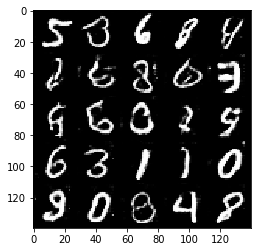

Epoch 2/2... Discriminator Loss: 0.9182... Generator Loss: 1.4133
Epoch 2/2... Discriminator Loss: 0.9375... Generator Loss: 1.0722
Epoch 2/2... Discriminator Loss: 0.9133... Generator Loss: 1.1157
Epoch 2/2... Discriminator Loss: 1.3795... Generator Loss: 0.6500
Epoch 2/2... Discriminator Loss: 0.7052... Generator Loss: 1.5258
Epoch 2/2... Discriminator Loss: 1.0220... Generator Loss: 0.9938
Epoch 2/2... Discriminator Loss: 0.9146... Generator Loss: 1.4412
Epoch 2/2... Discriminator Loss: 0.9850... Generator Loss: 0.8881
Epoch 2/2... Discriminator Loss: 0.9882... Generator Loss: 1.0345
Epoch 2/2... Discriminator Loss: 0.8400... Generator Loss: 1.6566


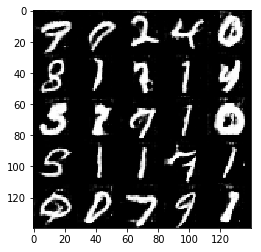

Epoch 2/2... Discriminator Loss: 0.7895... Generator Loss: 1.6421
Epoch 2/2... Discriminator Loss: 0.5877... Generator Loss: 1.6980
Epoch 2/2... Discriminator Loss: 0.7703... Generator Loss: 1.6577
Epoch 2/2... Discriminator Loss: 1.1008... Generator Loss: 0.9530
Epoch 2/2... Discriminator Loss: 1.2880... Generator Loss: 0.6894


In [12]:
batch_size = 32
z_dim = 100
learning_rate = 0.001
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.5079... Generator Loss: 9.1395
Epoch 1/1... Discriminator Loss: 0.7840... Generator Loss: 6.2636
Epoch 1/1... Discriminator Loss: 1.5978... Generator Loss: 0.4182
Epoch 1/1... Discriminator Loss: 1.7199... Generator Loss: 0.3607
Epoch 1/1... Discriminator Loss: 1.4368... Generator Loss: 0.5310
Epoch 1/1... Discriminator Loss: 1.4347... Generator Loss: 0.4700
Epoch 1/1... Discriminator Loss: 1.6519... Generator Loss: 0.3563
Epoch 1/1... Discriminator Loss: 1.1793... Generator Loss: 1.0922
Epoch 1/1... Discriminator Loss: 1.1739... Generator Loss: 0.7479
Epoch 1/1... Discriminator Loss: 1.2651... Generator Loss: 0.9673


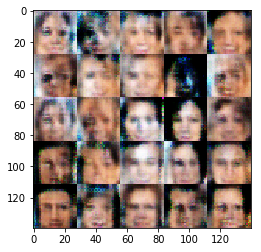

Epoch 1/1... Discriminator Loss: 1.2022... Generator Loss: 1.5226
Epoch 1/1... Discriminator Loss: 1.5877... Generator Loss: 0.4331
Epoch 1/1... Discriminator Loss: 1.1908... Generator Loss: 0.6499
Epoch 1/1... Discriminator Loss: 1.4751... Generator Loss: 0.5797
Epoch 1/1... Discriminator Loss: 1.9939... Generator Loss: 2.3787
Epoch 1/1... Discriminator Loss: 1.2686... Generator Loss: 0.9368
Epoch 1/1... Discriminator Loss: 1.2303... Generator Loss: 0.7593
Epoch 1/1... Discriminator Loss: 1.2851... Generator Loss: 0.7011
Epoch 1/1... Discriminator Loss: 1.2258... Generator Loss: 0.6924
Epoch 1/1... Discriminator Loss: 1.2616... Generator Loss: 0.7683


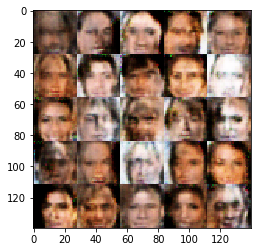

Epoch 1/1... Discriminator Loss: 1.1682... Generator Loss: 0.6972
Epoch 1/1... Discriminator Loss: 1.3461... Generator Loss: 0.6618
Epoch 1/1... Discriminator Loss: 1.3689... Generator Loss: 0.7048
Epoch 1/1... Discriminator Loss: 1.4092... Generator Loss: 0.7959
Epoch 1/1... Discriminator Loss: 1.5919... Generator Loss: 0.5885
Epoch 1/1... Discriminator Loss: 1.3948... Generator Loss: 0.8614
Epoch 1/1... Discriminator Loss: 1.4147... Generator Loss: 0.7333
Epoch 1/1... Discriminator Loss: 1.4737... Generator Loss: 0.6776
Epoch 1/1... Discriminator Loss: 1.3931... Generator Loss: 0.8651
Epoch 1/1... Discriminator Loss: 1.4250... Generator Loss: 0.8821


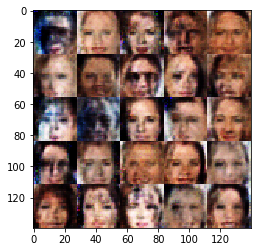

Epoch 1/1... Discriminator Loss: 1.4361... Generator Loss: 0.7911
Epoch 1/1... Discriminator Loss: 1.4380... Generator Loss: 0.7492
Epoch 1/1... Discriminator Loss: 1.3623... Generator Loss: 0.8292
Epoch 1/1... Discriminator Loss: 1.2824... Generator Loss: 0.8221
Epoch 1/1... Discriminator Loss: 1.3460... Generator Loss: 0.8747
Epoch 1/1... Discriminator Loss: 1.3755... Generator Loss: 0.7893
Epoch 1/1... Discriminator Loss: 1.3108... Generator Loss: 0.8192
Epoch 1/1... Discriminator Loss: 1.3400... Generator Loss: 0.6096
Epoch 1/1... Discriminator Loss: 1.5592... Generator Loss: 0.5131
Epoch 1/1... Discriminator Loss: 1.5693... Generator Loss: 1.2494


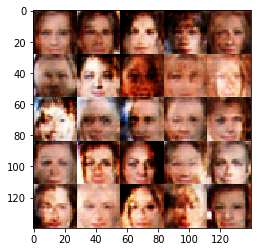

Epoch 1/1... Discriminator Loss: 1.3302... Generator Loss: 0.7193
Epoch 1/1... Discriminator Loss: 1.3880... Generator Loss: 0.6720
Epoch 1/1... Discriminator Loss: 1.3589... Generator Loss: 0.8570
Epoch 1/1... Discriminator Loss: 1.4374... Generator Loss: 0.8171
Epoch 1/1... Discriminator Loss: 1.4191... Generator Loss: 0.8131
Epoch 1/1... Discriminator Loss: 1.4396... Generator Loss: 0.7042
Epoch 1/1... Discriminator Loss: 1.3380... Generator Loss: 0.9037
Epoch 1/1... Discriminator Loss: 1.4334... Generator Loss: 0.6941
Epoch 1/1... Discriminator Loss: 1.3590... Generator Loss: 0.8180
Epoch 1/1... Discriminator Loss: 1.3712... Generator Loss: 0.7825


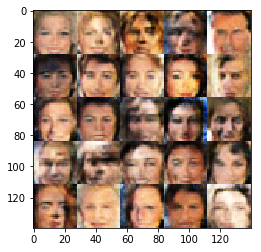

Epoch 1/1... Discriminator Loss: 1.2819... Generator Loss: 0.7492
Epoch 1/1... Discriminator Loss: 1.3347... Generator Loss: 0.9341
Epoch 1/1... Discriminator Loss: 1.3819... Generator Loss: 0.8265
Epoch 1/1... Discriminator Loss: 1.2888... Generator Loss: 0.8124
Epoch 1/1... Discriminator Loss: 1.3185... Generator Loss: 0.8291
Epoch 1/1... Discriminator Loss: 1.3351... Generator Loss: 0.6543
Epoch 1/1... Discriminator Loss: 1.3483... Generator Loss: 0.9144
Epoch 1/1... Discriminator Loss: 1.3143... Generator Loss: 0.8109
Epoch 1/1... Discriminator Loss: 1.3793... Generator Loss: 0.7622
Epoch 1/1... Discriminator Loss: 1.4100... Generator Loss: 0.7591


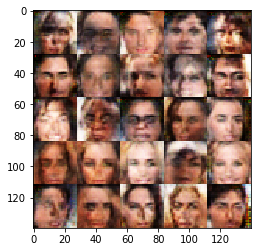

Epoch 1/1... Discriminator Loss: 1.3198... Generator Loss: 0.9117
Epoch 1/1... Discriminator Loss: 1.3769... Generator Loss: 0.8673
Epoch 1/1... Discriminator Loss: 1.3013... Generator Loss: 0.8960
Epoch 1/1... Discriminator Loss: 1.3628... Generator Loss: 0.9326
Epoch 1/1... Discriminator Loss: 1.3650... Generator Loss: 0.8359
Epoch 1/1... Discriminator Loss: 1.3398... Generator Loss: 0.8004
Epoch 1/1... Discriminator Loss: 1.3694... Generator Loss: 0.7167
Epoch 1/1... Discriminator Loss: 1.3831... Generator Loss: 0.6626
Epoch 1/1... Discriminator Loss: 1.3474... Generator Loss: 0.8503
Epoch 1/1... Discriminator Loss: 1.4490... Generator Loss: 0.6579


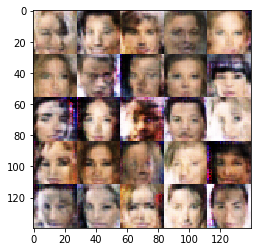

Epoch 1/1... Discriminator Loss: 1.2654... Generator Loss: 0.7559
Epoch 1/1... Discriminator Loss: 1.3355... Generator Loss: 0.7670
Epoch 1/1... Discriminator Loss: 1.3841... Generator Loss: 0.8735
Epoch 1/1... Discriminator Loss: 1.3457... Generator Loss: 0.8483
Epoch 1/1... Discriminator Loss: 1.3790... Generator Loss: 0.7497
Epoch 1/1... Discriminator Loss: 1.4410... Generator Loss: 0.8136
Epoch 1/1... Discriminator Loss: 1.4135... Generator Loss: 0.7246
Epoch 1/1... Discriminator Loss: 1.5059... Generator Loss: 0.5919
Epoch 1/1... Discriminator Loss: 1.3857... Generator Loss: 0.8306
Epoch 1/1... Discriminator Loss: 1.3579... Generator Loss: 0.6856


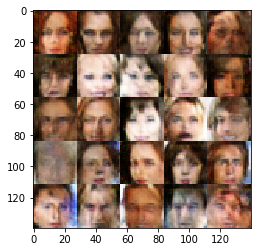

Epoch 1/1... Discriminator Loss: 1.3679... Generator Loss: 0.6535
Epoch 1/1... Discriminator Loss: 1.3512... Generator Loss: 0.8780
Epoch 1/1... Discriminator Loss: 1.2292... Generator Loss: 0.8256
Epoch 1/1... Discriminator Loss: 1.2408... Generator Loss: 0.7552
Epoch 1/1... Discriminator Loss: 1.3716... Generator Loss: 0.7308
Epoch 1/1... Discriminator Loss: 1.3157... Generator Loss: 0.8281
Epoch 1/1... Discriminator Loss: 1.3086... Generator Loss: 0.8123
Epoch 1/1... Discriminator Loss: 1.3737... Generator Loss: 0.5880
Epoch 1/1... Discriminator Loss: 1.4033... Generator Loss: 0.7904
Epoch 1/1... Discriminator Loss: 1.3627... Generator Loss: 0.7130


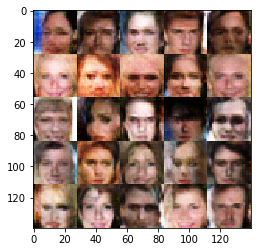

Epoch 1/1... Discriminator Loss: 1.3346... Generator Loss: 0.7708
Epoch 1/1... Discriminator Loss: 1.3131... Generator Loss: 0.7651
Epoch 1/1... Discriminator Loss: 1.3209... Generator Loss: 0.7301
Epoch 1/1... Discriminator Loss: 1.2785... Generator Loss: 0.7732
Epoch 1/1... Discriminator Loss: 1.3876... Generator Loss: 0.8250
Epoch 1/1... Discriminator Loss: 1.3512... Generator Loss: 0.7186
Epoch 1/1... Discriminator Loss: 1.3041... Generator Loss: 0.6635
Epoch 1/1... Discriminator Loss: 1.3954... Generator Loss: 0.7318
Epoch 1/1... Discriminator Loss: 1.4355... Generator Loss: 0.8177
Epoch 1/1... Discriminator Loss: 1.3733... Generator Loss: 0.7800


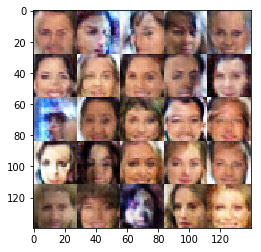

Epoch 1/1... Discriminator Loss: 1.3669... Generator Loss: 0.7640
Epoch 1/1... Discriminator Loss: 1.3924... Generator Loss: 0.6377
Epoch 1/1... Discriminator Loss: 1.2723... Generator Loss: 0.8098
Epoch 1/1... Discriminator Loss: 1.4142... Generator Loss: 0.8676
Epoch 1/1... Discriminator Loss: 1.3888... Generator Loss: 0.6645
Epoch 1/1... Discriminator Loss: 1.2848... Generator Loss: 0.9296
Epoch 1/1... Discriminator Loss: 1.3438... Generator Loss: 0.6471
Epoch 1/1... Discriminator Loss: 1.3151... Generator Loss: 0.7137
Epoch 1/1... Discriminator Loss: 1.3581... Generator Loss: 0.7732
Epoch 1/1... Discriminator Loss: 1.3212... Generator Loss: 0.8361


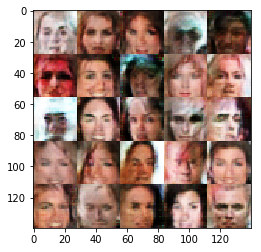

Epoch 1/1... Discriminator Loss: 1.3266... Generator Loss: 0.9652
Epoch 1/1... Discriminator Loss: 1.3474... Generator Loss: 0.8050
Epoch 1/1... Discriminator Loss: 1.3748... Generator Loss: 0.5919
Epoch 1/1... Discriminator Loss: 1.4321... Generator Loss: 0.7536
Epoch 1/1... Discriminator Loss: 1.3738... Generator Loss: 0.7523
Epoch 1/1... Discriminator Loss: 1.3253... Generator Loss: 0.8188
Epoch 1/1... Discriminator Loss: 1.4234... Generator Loss: 0.7429
Epoch 1/1... Discriminator Loss: 1.2031... Generator Loss: 0.6867
Epoch 1/1... Discriminator Loss: 1.1855... Generator Loss: 0.8482
Epoch 1/1... Discriminator Loss: 1.2917... Generator Loss: 0.9219


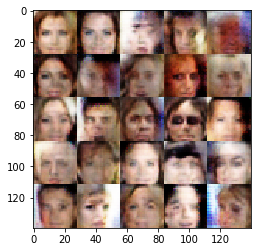

Epoch 1/1... Discriminator Loss: 1.3522... Generator Loss: 0.7963
Epoch 1/1... Discriminator Loss: 1.3127... Generator Loss: 0.8586
Epoch 1/1... Discriminator Loss: 1.3813... Generator Loss: 0.7199
Epoch 1/1... Discriminator Loss: 1.2559... Generator Loss: 0.7952
Epoch 1/1... Discriminator Loss: 1.3620... Generator Loss: 0.6987
Epoch 1/1... Discriminator Loss: 1.3741... Generator Loss: 0.7853


In [ ]:
batch_size = 32
z_dim = 100
learning_rate = 0.001
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.